<a href="https://colab.research.google.com/github/Absolutorcinus/Histogram_ct_scan/blob/master/notebooks/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PIP


In [ ]:
!pip uninstall spacy
!pip install spacy
!python -m spacy download en_core_web_lg
!pip install googletrans==3.1.0a0

In [ ]:
!pip uninstall plotly
!pip install plotly

In [ ]:
!python -m spacy download de_core_news_lg
!python -m spacy download en_core_web_trf

# Imports

In [285]:
import en_core_web_lg
import de_core_news_lg
import spacy 
from spacy.matcher import Matcher

from spacy import displacy

from tqdm.auto import tqdm
from spacy.tokens import DocBin

#Google Translate Ajax API to make calls to such methods as detect and translate.
#Performed better compared to Spacy in Language detection
from googletrans import Translator   

import pandas as pd 
import numpy as np
import re
import string




import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (f1_score,
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve)

import pickle

#multiprocessing used to apply map the function on our splitted dataset
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool



Importing the dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/data/cc_dataset.csv')

# Data Discovery

Checking if there are null values

In [8]:
df.isnull().values.any()                                                        #check if there are null values

False

Describing the dataset

In [9]:
df.describe()                                                                   #Getting the Description of our data

text language sentiment
count   91388    91388     91388
unique  90610        2         2
top     Danke       en       neg
freq       32    51658     47764

**drop the duplicates**<br>
we can perform that before the language check  because the the duplicates represets 1% of our entire dataset.therefore it wont have an important impact
on the results later on

In [10]:
df.drop_duplicates(subset=['text'],inplace=True)
df.reset_index(drop=True,inplace=True)

## Language Detection

**Checking the languages**<br>
we need to create english and german models<br>
in this part i will analyze the the languages of the texts


for that I have compared the results based on spacy-langdetect and Googletrans on a sample from our dataset:<br>

the performace of googletrans was the more accurate than spacy-langdetect
thus my choice to use googletrans.

In [6]:
#create an object of the Translator class from googletrans
translator  = Translator()

In [7]:
'''
this function gets dataframe, uses the column 'text'
adds two new columns 'language_detected' where it puts 
the language detected and 'confidence' for the score of
the prediction
'''
def func(df1):
  df1['language_detected'] = df1['text'].apply(lambda x: translator.detect(x).lang)
  df1['confidence'] = df1['text'].apply(lambda x:translator.detect(x).confidence)
  return df1



In [ ]:
#split our dataset into 50
df_split = np.array_split(df, 50)

In [ ]:
#Use multiprocessing
num_jobs = 50
pool = Pool(num_jobs)
with pool as p:
  a = (p.map(func, df_split))

In [ ]:
#concatenate the list of dfs
a = pd.concat(a)

In [ ]:
#save the data as csv
a.to_csv("/content/drive/MyDrive/data/languagedetected.csv")

In [ ]:
#formating the data type
a.language_detected = a.language_detected.astype(str)
a.confidence = a.confidence.astype(str) #because there are cases where there was two languages detected and as a result we have an array in the confidence

In [ ]:
df = a 

## Splitting Dataset

**split data into  German and English**

In [11]:
en_df = df[df['language']=='en']
de_df = df[df['language']=='de']
#dropping the language  columns
de_df.drop('language',axis='columns', inplace=True)
en_df.drop('language',axis='columns', inplace=True)
# resetting the index
en_df.reset_index(drop=True, inplace=True)
de_df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Distribution of the detected languages

**visualization of the distribution of the detected languages in our english**

In [ ]:
# Here we use a column with categorical data
fig = px.histogram(en_df, x="language_detected")
fig.show()

histogram of the distribution of the languages detected in the sentences that were labeled as english

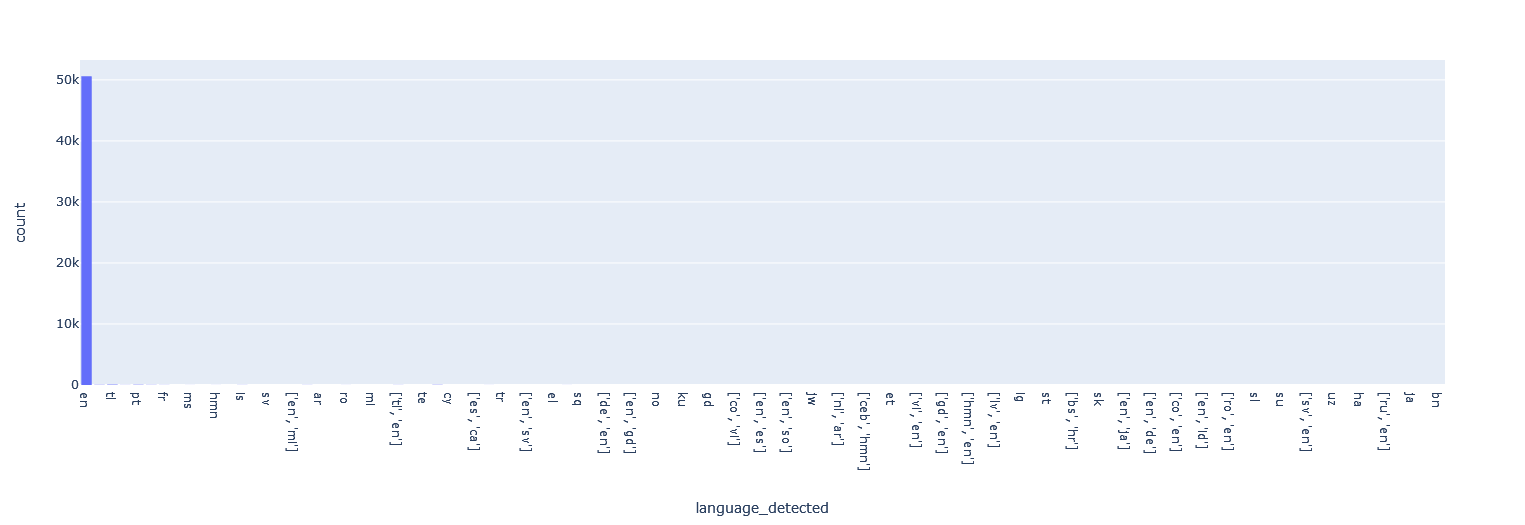

## Some Cleaning & Ordering 🧹🧹🧹

### first stage: cleaning based on the detected languages 

In [ ]:
print(f"sentences marked as english but detected as multiple languages:\n {en_df[(en_df.confidence.str.contains(',')) & (en_df.confidence.str.contains(','))].count()}")

print(f"sentences marked as german but detected as multiple languages:\n {de_df[(de_df.confidence.str.contains(',')) & (de_df.confidence.str.contains(','))].count()}")


sentences marked as english but detected as multiple languages:
 text                 102
sentiment            102
language_detected    102
confidence           102
dtype: int64
sentences marked as german but detected as multiple languages:
 text                 93
sentiment            93
language_detected    93
confidence           93
dtype: int64


#### we will remove the rows where the detected language has two values

In [ ]:
#keep the rows that have only one language multiple language 
en_df = en_df[(~en_df.language_detected.str.contains(',')) & (~en_df.confidence.str.contains(','))]#the confidence  condition is not necessary
de_df = de_df[(~de_df.language_detected.str.contains(',')) & (~de_df.confidence.str.contains(','))]

In [ ]:
#viz = de_df.language_detected.value_counts().reset_index().rename(columns={'index': 'language', 'language_detected': 'lang_count' })

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=en_df.language_detected))
fig.add_trace(go.Histogram(x=de_df.language_detected))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

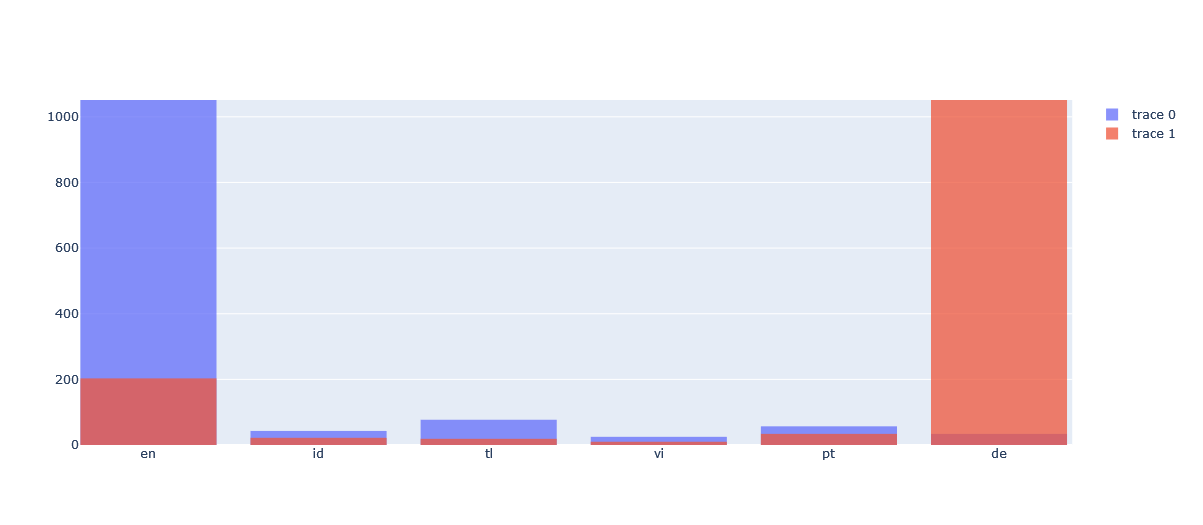

based on the histogram we notice there are **german sentences**  that were **labeled as english** and some small portion of **english sentences** that were labeled as german

#### we will reorganize the mislabeled texts

we will check in the english dataset: en_df the text whose languages were labeled as english:en and predicted as german:de, if we see that the confidence score is 1 then we move it to the german dataset: de_df

we will check in the german dataset: de_df the text whose languages were labeled as german:de and predicted as english:en, if we see that the confidence score is 1 then we move it to the german dataset: de_df

In [ ]:
en_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51118 entries, 0 to 51219
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               51118 non-null  object
 1   sentiment          51118 non-null  object
 2   language_detected  51118 non-null  object
 3   confidence         51118 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [ ]:
de_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39297 entries, 0 to 39389
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               39297 non-null  object 
 1   sentiment          39297 non-null  object 
 2   language_detected  39297 non-null  object 
 3   confidence         39297 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.5+ MB


In [ ]:
#changing the datatype of the confidence column in the english dataset
en_df['confidence'] = en_df['confidence'].astype(float)
#changing the datatype of the confidence column in the german dataset
de_df['confidence'] = de_df['confidence'].astype(float)

In [ ]:
en_df[(en_df.language_detected.str.contains('de')) & (en_df.confidence==1.)].count()

text                 14
sentiment            14
language_detected    14
confidence           14
dtype: int64

there are ~14 german texts that were labeled as english

In [ ]:
#en_df[(en_df.language_detected.str.contains('de')) & (en_df.confidence==1.)]

In [ ]:
de_df[(de_df.language_detected.str.contains('en')) & (de_df.confidence==1.)].count()

text                 58
sentiment            58
language_detected    58
confidence           58
dtype: int64

there are ~58  english texts that were labeled as german

We will add the german sentences from english dataset to the german dataset<br>
We will add the english sentences from german dataset to the english dataset




In [ ]:
de_df = pd.concat([de_df, en_df[(en_df.language_detected.str.contains('de')) & (en_df.confidence==1.)] ])

In [ ]:
en_df = pd.concat([en_df,de_df[(de_df.language_detected.str.contains('en')) & (de_df.confidence==1.)] ])

### remove the rest of the other languages from our dataset

In [ ]:
en_df = en_df[(en_df.language_detected == 'en')]
de_df = de_df[(de_df.language_detected == 'de')]

In [ ]:
#drop language_detected   and  confidence  columns to keep only text and sentiment

en_df.drop(['language_detected','confidence'], axis=1, inplace=True)
de_df.drop(['language_detected','confidence'], axis=1, inplace=True)

In [ ]:
print(en_df.info())
print(de_df_info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50655 entries, 0 to 39053
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       50655 non-null  object
 1   sentiment  50655 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38779 entries, 0 to 51094
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       38779 non-null  object
 1   sentiment  38779 non-null  object
dtypes: object(2)
memory usage: 908.9+ KB
english dataset info: 
None  None


In [ ]:
en_df.reset_index(drop=True,inplace=True)
de_df.reset_index(drop=True,inplace=True)

In [ ]:
en_df.describe()

text sentiment
count                                        50655     50655
unique                                       50655         2
top     i am at interchange .. Just missed the bus       pos
freq                                             1     28810

In [ ]:
de_df.describe()

text sentiment
count                                               38779     38779
unique                                              38779         2
top     Leslie heilt von einem klitzekleinen Spinnenbi...       neg
freq                                                    1     25191

saving the datasets

In [ ]:
de_df.to_csv("/content/drive/MyDrive/data/de_df.csv")
en_df.to_csv("/content/drive/MyDrive/data/en_df.csv")

# Data Preprocessing

## Import dataset: result of the data discovering

importing our en/de datasets

In [ ]:
en_df = pd.read_csv("/content/drive/MyDrive/data/en_df.csv")
de_df = pd.read_csv("/content/drive/MyDrive/data/de_df.csv")
# selecting the columns text and sentiment(just in case)
de_df = de_df[['text','sentiment']]
en_df = en_df[['text','sentiment']]

In [9]:
#checking our datasets
#en_df
#de_df

## loading our nlp models for english and german for the preprocessing

In [4]:
en_nlp = spacy.load("en_core_web_lg")
de_nlp = spacy.load("de_core_news_lg")
en_nlp_trf = spacy.load("en_core_web_trf")

#selecting german/english models that are going to be of use for the preprocessing
nlp = en_nlp

Multiprocessing function for parallel computation

In [5]:
def multi_process_df(func,df,num_splits):

  

  #split our dataset into #num_splits
  df = np.array_split(df, num_splits)
  #Use multiprocessing
  num_jobs = num_splits
  pool = Pool(num_jobs)
  with pool as p:
    list_dfs = (p.map(func, df))
  return pd.concat(list_dfs)

## Format text column as string String

In [319]:
def format_text_to_string(df):
   df['text'] = df['text'].astype(str)
   return(df)

## Lowercasing 

In [320]:
def to_lower(df):
  to_lower_case = lambda x: x.lower()
  df['text'] = df['text'].apply(to_lower_case)
  return df

## Removing URLs, Emails, digits and dates from text

In [321]:
#the function will be used on any language() german and english texts )to remove emails and url
#t refers to token
def remove_email_url_digit_dates_text(texto):
  doc = nlp(texto)
  #in this part I will use the rule based Matching to remove urls emails and digits
  texto = str(" ".join([t.text for t in doc if not(t.like_url | t.like_email | t.is_digit )] ))
  #in this part i will use NER to remove  dates from texts
  a = [{"text": ent.text, "label": ent.label_} for ent in doc.ents]
  list_dates_text = list((item["text"] for item in a if item["label"] == "DATE"))

  for elem in list_dates_text:
    texto = texto.replace(elem , "") 

  return(texto)



#applying it on the dataframe
def remove_email_url_digit_dates_df(df):
  # remove all the urls and emails in an individual text
  df['text'] = df['text'].apply(lambda x: remove_email_url_digit_dates_text(x)) #apply it on our dataset text column
  return df

In [ ]:
dft=en_df[:100]
dft

text sentiment
0          i am at interchange .. Just missed the bus       neg
1                                         I'll do it!       pos
2   What was your favorite part of the 80's?? For ...       pos
3                                         Cavsssssss!       neg
4   I posted my '91 Golf up for sale last night an...       neg
..                                                ...       ...
95                                     That's so sad.       neg
96             Sickness and vacations do not mix well       neg
97  Voting for teen choice awards lmao. *helen &lt;3*       pos
98  pretty, tho, if clear! I would imagine the bus...       pos
99  Best twitter friend this old hippie could ask ...       pos

[100 rows x 2 columns]

In [ ]:
#multi_process_df(remove_email_url_df, experimental_df, 50)

## Removing Punctuation

In [322]:
#the function will be used for german and english texts to 
#t refers to token
def remove_punctuations_text(texto):
  doc = nlp(texto)
  
  return str(" ".join([t.text for t in doc if not (t.is_punct)] ) )

def remove_punctuations_df(df):
  df['text'] = df['text'].apply(lambda x: remove_punctuations_text(x))          #apply it on our dataset text column
  return df

## Removing Stop Words

In [323]:
#english stop words set
en_sw_spacy = en_nlp.Defaults.stop_words
#German stop words set
de_sw_spacy = de_nlp.Defaults.stop_words

sw_list = en_sw_spacy

In [324]:
def remove_stop_words(df,sw_list):

  remove_en_stop_words = lambda x: " ".join( [x for x in x.split() if x.lower() not in sw_list] )
  df['text'] = df['text'].apply(remove_en_stop_words)

  return df


## Lemmatization

In [325]:
def lemmatize_text(texto):
  doc = nlp(texto)
  return str(" ".join([t.lemma_ for t in doc ]) )

def lematize_df(df):
  df['text'] = df['text'].apply(lambda x: lemmatize_text(x))          #apply it on our dataset text column
  return df

## Drop empty rows

In [327]:
def drop_empty_rows(df):
  df['text'].replace('', np.nan, inplace=True)
  df.dropna(inplace=True)
  return df.reset_index(drop=True,inplace=True)

## Pipeline:
1. Lowercasing
2. removing the Email addresses and Websites
2. remove punctuation
3. remove stopwords
4. Lemmatization

stopwords should be removed after punctuation to avoid the case where we have [stopword][punctuation] <br>
for example : "What!"  will remain "What!" if we dont remove  first thepunctuation


---
**english stop words set**<br>
en_sw_spacy <br>
**German stop words set:**<br>
de_sw_spacy <br><br>

**EnglishSpacyModel:**<br>
en_nlp = spacy.load("en_core_web_lg")<br>
**GermanSpacyModel:**<br>
de_nlp = spacy.load("de_core_news_lg")<br><br>
**english dataset:**<br>
en_df<br>
**German dataset:**<br>
de_df

---
list of functions:
1. format_text_to_string(df) : <br>
1. to_lower(df) : <br>
2. remove_email_url_digit_dates_df(df) : <br>
3. remove_punctuations_df(df) : <br>
4. remove_stop_words(df,sw_list) : <br>
5. lemmatize_df(df) : <br>
6. drop_empty_rows(df) : 



In [328]:
def  pipeline_nlp(df, language='de'):

  global nlp
  global sw_list

  format_text_to_string(df)
  to_lower(df)
  remove_email_url_digit_dates_df(df)
  remove_punctuations_df(df)

  #in case we have english dataset we need to use english stopwords and english nlp Spacy model 
  if language == "en":
    #change nlp model into the english 
    nlp = en_nlp
    #change stop word list to english
    sw_list = en_sw_spacy

    remove_stop_words(df,sw_list)
    

  #in case we have german dataset we need to use german stopwords and german nlp Spacy model 
  elif language == "de":
    #change nlp model into the german 
    nlp = de_nlp
    #change stop word list to german
    sw_list = de_sw_spacy

    remove_stop_words(df,sw_list)
    
  lematize_df(df)
  drop_empty_rows(df)
  print(f"NLP: {nlp}  stop_words: {sw_list}")
  return df

---

In [ ]:
my_en_df = multi_process_df(pipeline_nlp, en_df, 50).reset_index(drop=True)

In [ ]:
#save the result into the csv file
my_en_df.to_csv("/content/drive/MyDrive/data/en_after_lematization.csv")

**I have changed the nlp variable to the de_nlp from Spacy and the sw:stopwords into de_sw **

In [ ]:
my_de_df = multi_process_df(pipeline_nlp, de_df, 50).reset_index(drop=True)

In [ ]:
my_de_df

I am very suspescious about the german dataset as I have noticed the sentiments attributed to the sentences are not correct

In [ ]:
#save the result into csv file
my_de_df.to_csv("/content/drive/MyDrive/data/de_after_lemmatization.csv")


🚩🚩 Need to optimise the multiprocessing  fucntion and include the choice of language

However I think for working with different languages either we can create a translator in case we do not have  a pretrained model

---

## Importing our saved data folowwing the execution of the preprocessing pipeline

In [130]:
en_df = pd.read_csv('/content/drive/MyDrive/data/en_after_lematization.csv')[['text','sentiment']]
de_df = pd.read_csv('/content/drive/MyDrive/data/de_after_lemmatization.csv')[['text','sentiment']]
drop_empty_rows(en_df)
drop_empty_rows(de_df)

In [ ]:
#quot; @; 

In [9]:
en_df.groupby("sentiment").text.count().reset_index()

sentiment   text
0       neg  21738
1       pos  28602

In [10]:
de_df.groupby("sentiment").text.count().reset_index()

sentiment   text
0       neg  25003
1       pos  13468

## Word Analysis

concatenating all the text in the english dataset together

In [15]:
all_text_en = " ".join(en_df.text.to_list())
all_text_de = " ".join(de_df.text.to_list())

Lets check the negative and positive texts tokens for both languages

In [84]:
#this function gets the df and the column name that contains  the text(tweets)
#and returns  tuple of concatenated text and df of the words used in our dataset

def extract_wrods_from_df(df, text_column, sentiment):

  sent_df = df[df[text_column] == sentiment]
  all_text = " ".join(sent_df.text.to_list())
  all_text_splited = all_text.split()

  return  (all_text, pd.DataFrame(all_text_splited, columns = ['words']))

In [70]:
def draw_wordcloud(size,list_wc):

  figure, axarr = plt.subplots(2,2,figsize=size)
  axarr[0,0].imshow(list_wc[0])
  axarr[0,1].imshow(list_wc[1])
  axarr[1,0].imshow(list_wc[2])
  axarr[1,1].imshow(list_wc[3])

  #plt.figure(figsize = size) 
  plt.axis("off")

In [48]:
#extract_wrods_from_df(en_df, 'sentiment','neg')[1].value_counts().rename_axis('unique_values').reset_index(name='counts')

let's check the word cloud of each sentiment from each language dataset

In [49]:
wordcloud_en_pos = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state = 10, 
                      collocations = False, 
                      background_color = 'white', 
                      colormap = 'tab20b').generate(extract_wrods_from_df(en_df, 'sentiment','pos')[0])

wordcloud_en_neg = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state = 10, 
                      collocations = False, 
                      background_color = 'black', 
                      colormap = 'tab20b').generate(extract_wrods_from_df(en_df, 'sentiment','neg')[0])

wordcloud_de_pos = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state = 10, 
                      collocations = False, 
                      background_color = 'white', 
                      colormap = 'tab20b').generate(extract_wrods_from_df(de_df, 'sentiment','pos')[0])

wordcloud_de_neg = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state = 10, 
                      collocations = False, 
                      background_color = 'black', 
                      colormap = 'tab20b').generate(extract_wrods_from_df(de_df, 'sentiment','neg')[0])

In [51]:
list_wc = [wordcloud_en_pos, wordcloud_en_neg, wordcloud_de_pos, wordcloud_de_neg]

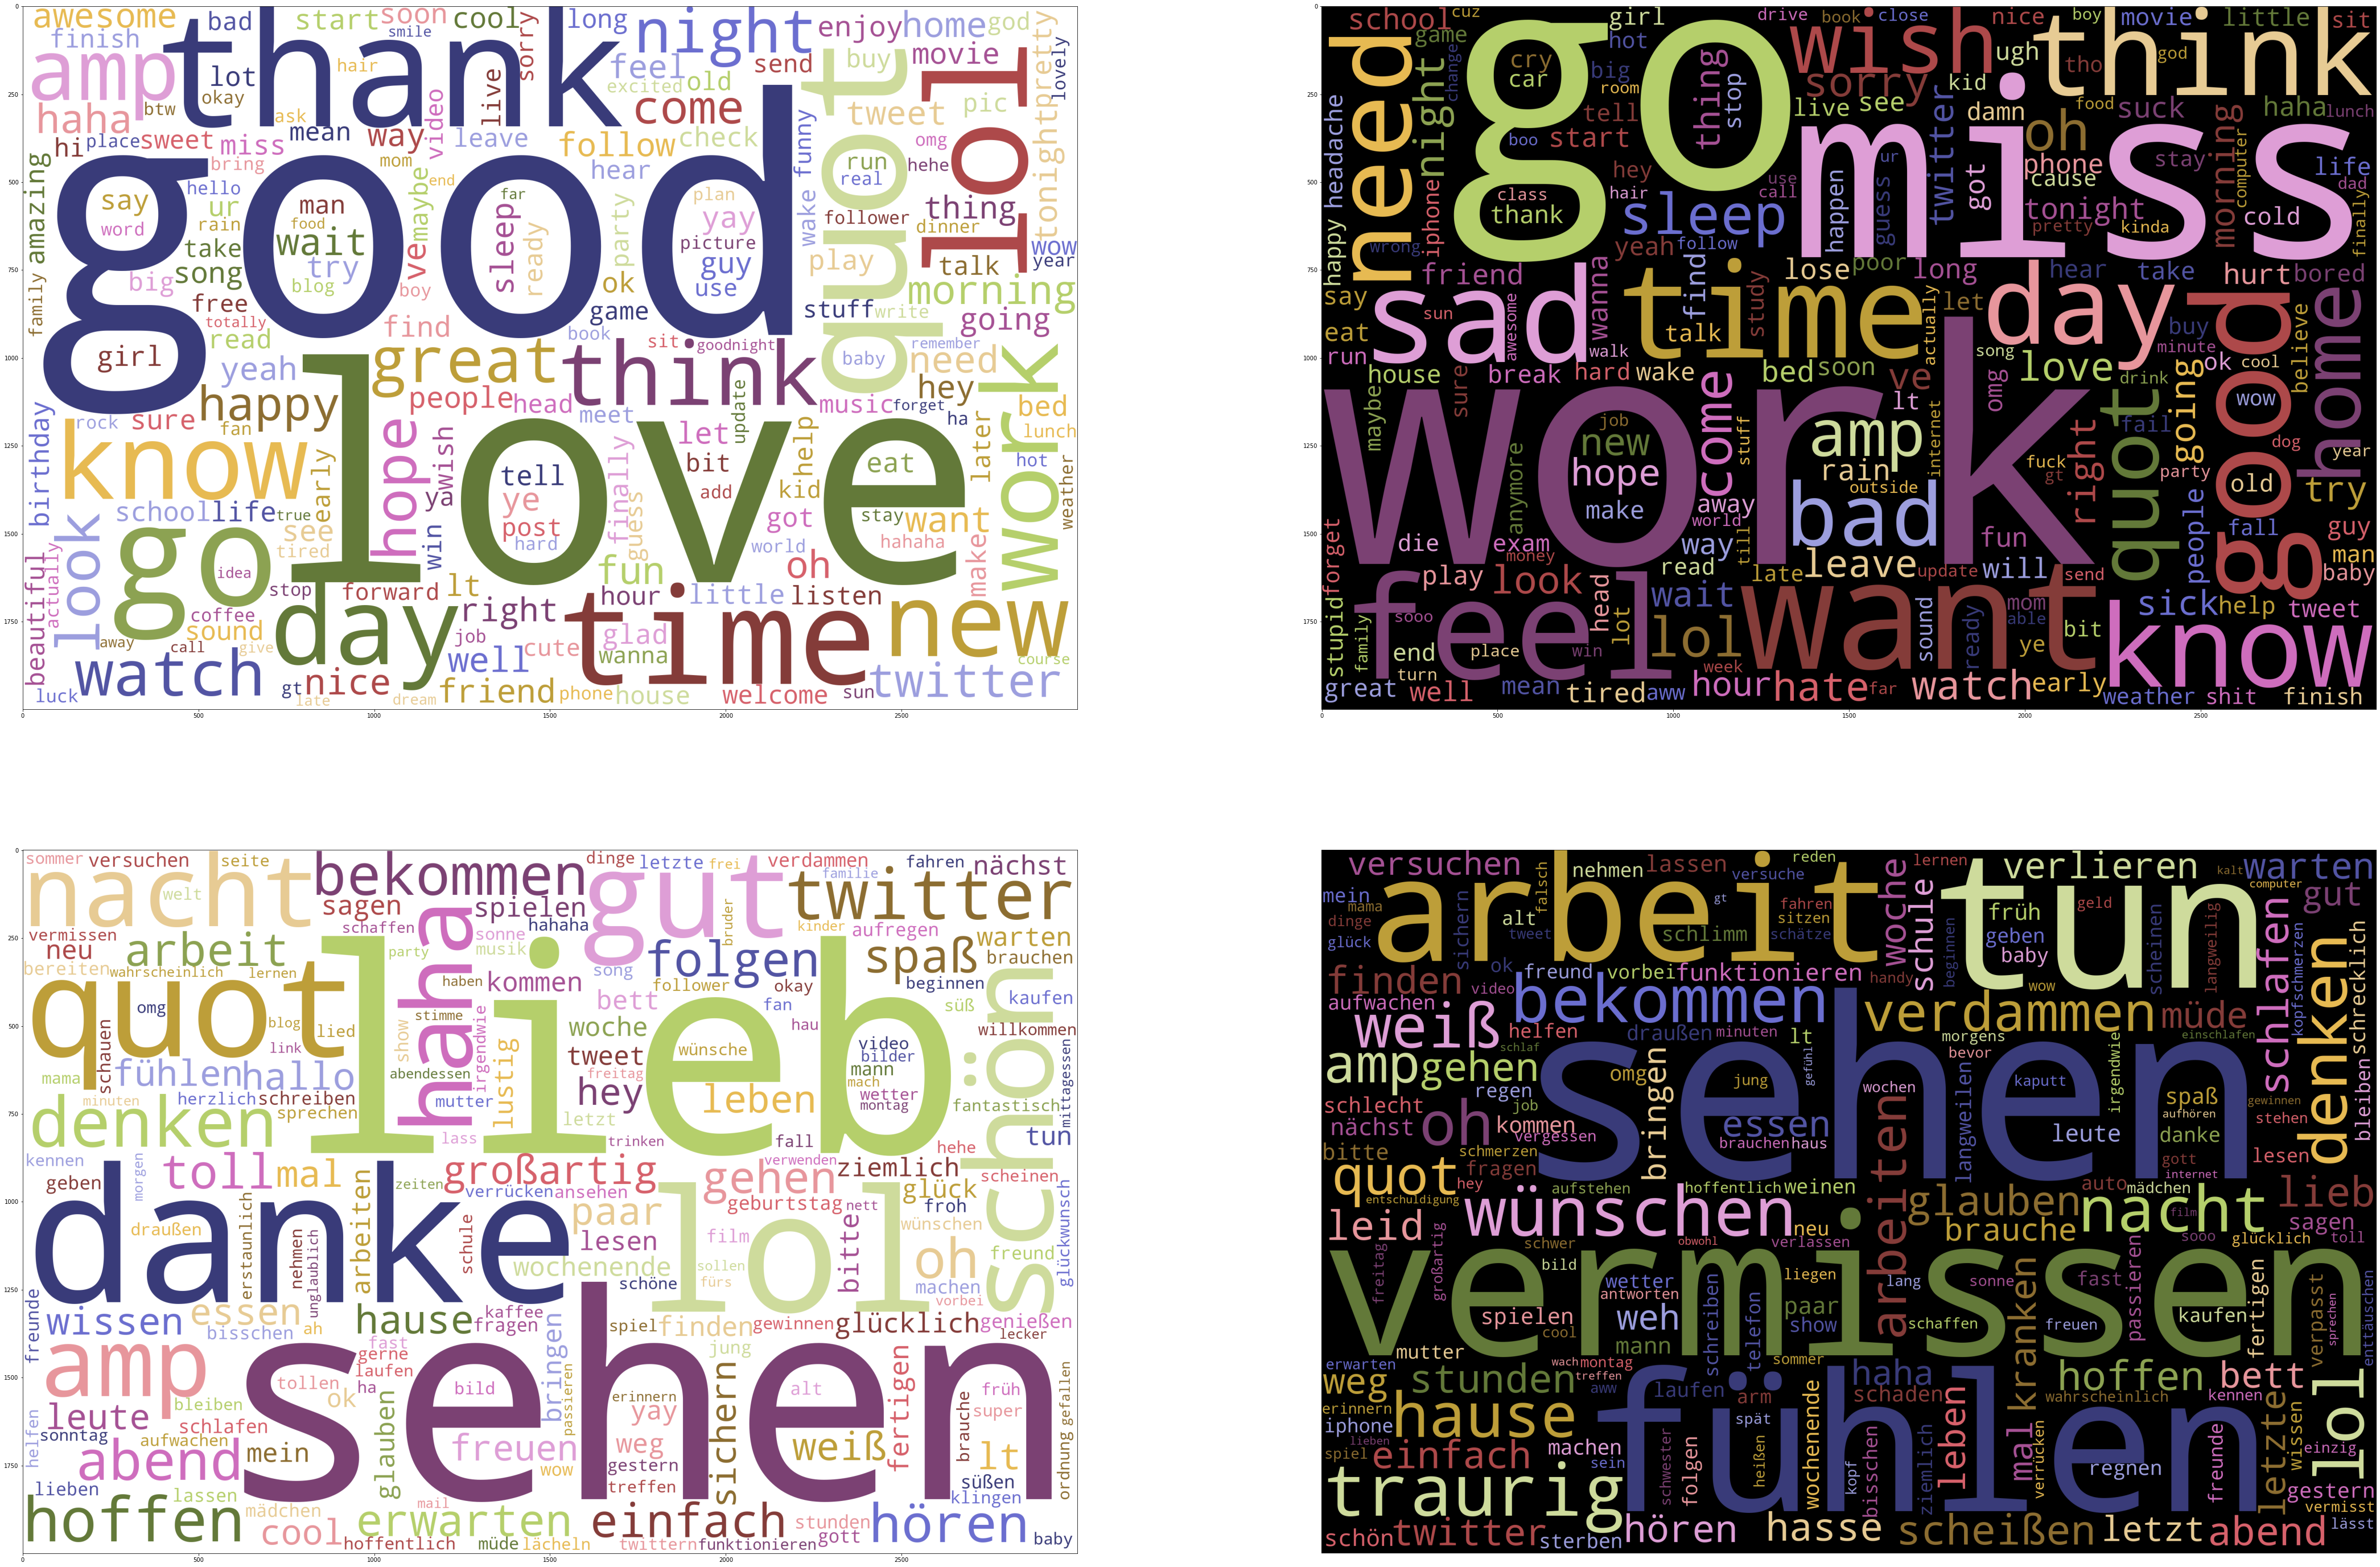

In [71]:
draw_wordcloud((75,50),list_wc)

Checking token's Tags VERB, ADJ, ADP

In [17]:
#print(len(all_text_en))#1808142 =>[E088] Text of length exceeds maximum of 1000000. The v2.x parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input
#nlp.max_length = 3493895 

#doc = en_nlp(all_text_en, disable = ['ner','parser'])#25s

#doc = en_nlp(all_text_en)

1808142


In [72]:
print(len(en_df))

50340


In [78]:
nlp_en = en_nlp
nlp_en.max_length = 3493895 
doc_en = nlp_en(" ".join(en_df.text.to_list()), disable = ['ner','parser'])

In [83]:
#excluded_tags = {"VERB", "ADJ", "ADP"}
#included_tags = {"PROPN", "NOUN"}
#included_tags = {"VERB"}
included_tags = {"ADJ"}
tokens_list = [token.text for token in doc_en if token.pos_ in included_tags]   
print(tokens_list[:20])

words_pos = [''.join(c for c in s if c not in string.punctuation) for s in tokens_list] #remove punctuation
words_pos = [i.strip() for i in words_pos]                                              #remove white space
words_pos = [i for i in words_pos if i]                                                 #remove empty strings
words_pos = [i.lower() for i in words_pos]   

['favorite', 'fair', 'sad', 'wrong', 'dead', 'awesome', 'great', 'tidy', 'nice', 'basic', 'massive', 'daft', 'posh', 'smart', 'desperate', 'cool', 'lucky', 'cool', 'deep', 'late']


In [68]:
df = df.value_counts().rename_axis('unique_values').reset_index(name='counts')

In [71]:
df[(df['counts']<100) & (df['unique_values'].str.len() <= 2)]

unique_values  counts
496              cd      97
508               e      93
513              da      92
555              uk      83
585              yo      79
...             ...     ...
32094            iu       1
32167            hb       1
32210            hc       1
32705            hu       1
32898            hj       1

[683 rows x 2 columns]

I think those words are not relevant to in our sentences
Probably they need to be removed 

In [ ]:
fig = px.bar(df[(df['unique_values'].str.len() <= 2)| (df['unique_values'].str.isnumeric()) ], x="unique_values", y="counts")
fig.show()

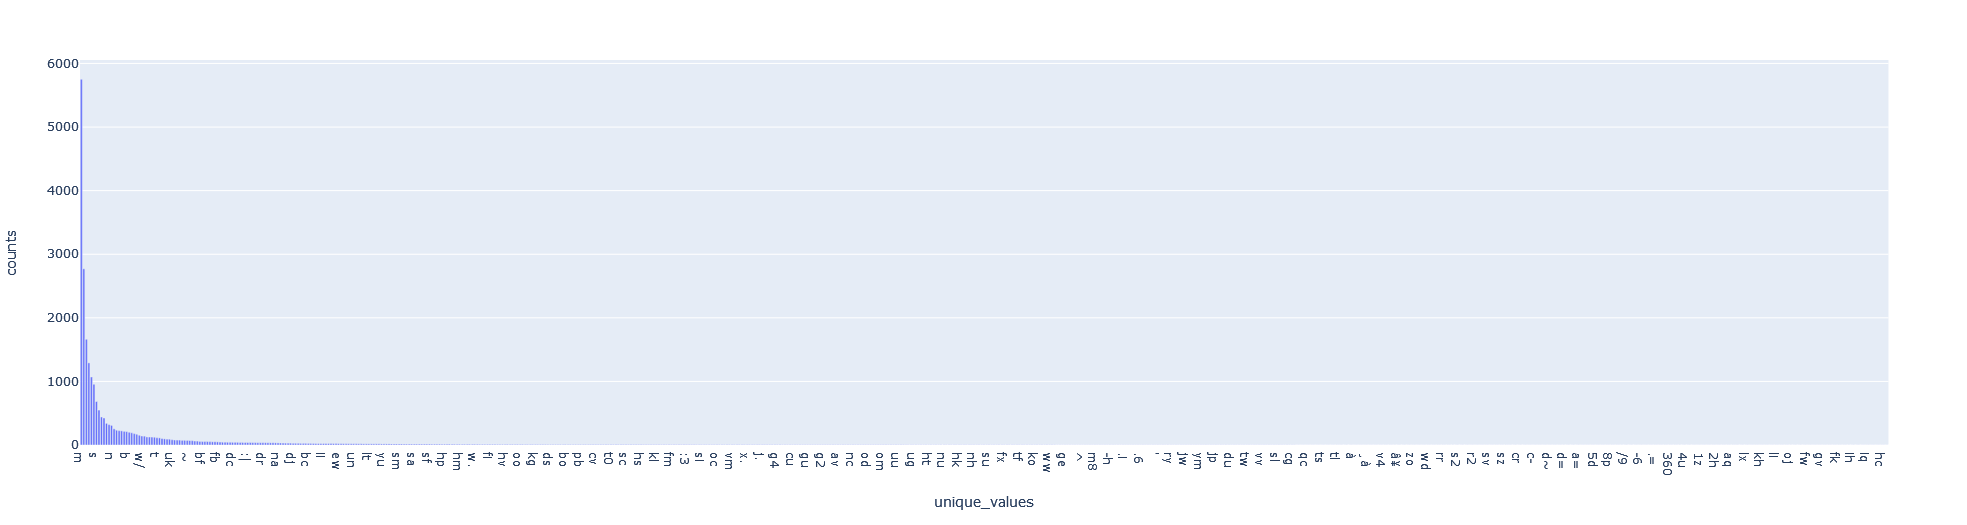

need to remove 1 and two letters words from our dataset because they do not add any meaning to the sentence 

In [120]:
#lets get the list of words made with 2 or 1 character:
def remove_words(en_df):
  all_text = " ".join(en_df.text.to_list())
  all_text = all_text.split()

  all_text_df = pd.DataFrame(all_text, columns = ['words'])
  list_of_words_to_remove = set(all_text_df[(all_text_df['words'].str.len() <= 2)| (all_text_df['words'].str.isnumeric())].words.to_list())#.value_counts()
  remove_stop_words(en_df,list_of_words_to_remove)
  en_df = en_df[en_df['text'] != '']
  return en_df

I can use this function: remove_stop_words(df,sw_list) to remove the words that are made of two characters 

In [131]:
de_df = remove_words(de_df)
en_df = remove_words(en_df)

## 0 : neg  ,1: pos

In [133]:
en_df['sentiment'] = en_df.sentiment.map({'neg':0, 'pos':1})
de_df['sentiment'] = de_df.sentiment.map({'neg':0, 'pos':1})

In [139]:
en_df.to_csv("/content/drive/MyDrive/data/en_df_final.csv")
de_df.to_csv("/content/drive/MyDrive/data/de_df_final.csv")

In [125]:
#en_df = en_df[en_df['text'] != '']

# Model Planning

## English

In [251]:
X = en_df.drop('sentiment', axis=1)
y = en_df[['sentiment']]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [194]:
X

text
0                          interchange miss bus
1                                      favorite
2                                    cavsssssss
3        post golf sale night fair interest sad
4                      wrong chicken finger fry
...                                         ...
50335                                   aww lol
50336                                heyyy twit
50337  ass jayvon sey quot;pull pant negro&quot
50338                      hehe check link 4got
50339                                lmfao depp

[50239 rows x 1 columns]

In [195]:
#vectorize my input
X = np.array([en_nlp(el).vector for el in list(X.text)])

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [198]:
print(f" shape X_train: {np.shape(X_train)}, shape y_train: {np.shape(y_train)} ")
print(f" shape X_test: {np.shape(X_test)}, shape y_test: {np.shape(y_test)} ")

 shape X_train: (37679, 300), shape y_train: (37679, 1) 
 shape X_test: (12560, 300), shape y_test: (12560, 1) 


## German

In [270]:
#runtime:(4,29min)
def vectorize_and_split(en_df):
  X = en_df.drop('sentiment', axis=1)
  y = en_df[['sentiment']]
  X = np.array([de_nlp(el).vector for el in list(X.text)])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
  print(f" shape X_train: {np.shape(X_train)}, shape y_train: {np.shape(y_train)} ")
  print(f" shape X_test: {np.shape(X_test)}, shape y_test: {np.shape(y_test)} ")

  return [X_train,y_train,X_test,y_test]

In [271]:
german_data = vectorize_and_split(de_df)

 shape X_train: (28822, 300), shape y_train: (28822, 1) 
 shape X_test: (9608, 300), shape y_test: (9608, 1) 


# Model Building

## ENGLISH

In [ ]:
lr_model = LogisticRegression().fit(X_train, y_train)
print(lr_model.score(X_train, y_train))

## GERMAN

In [ ]:
de_lr_model = LogisticRegression().fit(german_data[0], german_data[1])
print(de_lr_model.score(german_data[0], german_data[1]))

# Model Testing & Results

Example: 

> text = "I love this cup of tea "<br>
> a = (en_nlp(text).vector)<br>
> np.shape(a)<br>
> lr_model.predict(np.reshape(a,(1,300) ))<br>

RESULT: array([1])

## ENGLISH

In [224]:
y_pred = lr_model.predict(X_test)
print(lr_model.score(X_test, y_test))

0.7363057324840764


In [280]:
en_confusion_matrix = confusion_matrix(y_test, y_pred)

In [250]:
text = "I love this cup of tea "
a = (en_nlp(text).vector)
np.shape(a)

lr_model.predict(np.reshape(a,(1,300) ))

array([1])

roc_auc_score of the existing model ==> 0.7232848496234112


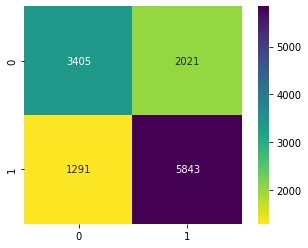

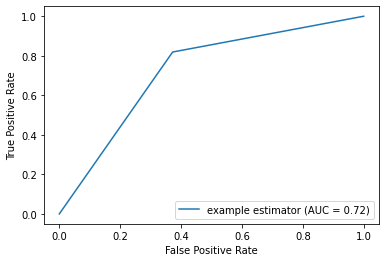

In [281]:
ax = sns.heatmap(en_confusion_matrix, cmap='viridis_r', annot=True, fmt='d', square=True)


print(f'roc_auc_score of the existing model ==> {roc_auc_score(y_test, y_pred)}')
#0.5 means that our classifier has a bad training algorithm 


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

plt.show()

In [273]:


file_name = "/content/drive/MyDrive/model/en_nlp_lr_model.pkl"
with open(file_name,'wb')as file:
    pickle.dump(lr_model,file)
    


## GERMAN

In [275]:
de_y_pred = de_lr_model.predict(german_data[2])
print(de_lr_model.score(german_data[2], german_data[3]))

0.7258534554537885


In [282]:
de_confusion_matrix = confusion_matrix(german_data[3], de_y_pred)

roc_auc_score of the existing model ==> 0.6634834601740859


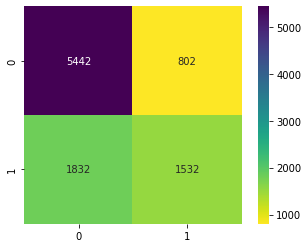

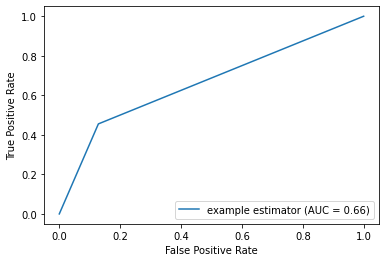

In [283]:
ax = sns.heatmap(de_confusion_matrix, cmap='viridis_r', annot=True, fmt='d', square=True)


print(f'roc_auc_score of the existing model ==> {roc_auc_score(german_data[3], de_y_pred)}')
#0.5 means that our classifier has a bad training algorithm 



fpr, tpr, thresholds = metrics.roc_curve(german_data[3], de_y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

plt.show()

In [277]:
file_name = "/content/drive/MyDrive/model/de_nlp_lr_model.pkl"
with open(file_name,'wb')as file:
    pickle.dump(de_y_pred,file)

# Operationalizing (FastAPI)

In [286]:
def upload_model(path_of_model) :
  
  with open(path_of_model,'rb') as file:
    lr_model = pickle.load(file)

  return lr_model

In [287]:
classifier = upload_model('/content/drive/MyDrive/model/en_nlp_lr_model.pkl')

In [355]:
def get_sentiment(text, path_of_model, nlp):
  data = [[text, 0]]

# Create the pandas DataFrame
  df = pd.DataFrame(data, columns = ['text', 'sentiment'])
  text = pipeline_nlp(df, language='en').text[0]
  print(text)
  with open(path_of_model,'rb') as file:
    lr_model = pickle.load(file)
  #text = "I love this cup of tea "
  text = (nlp(text).vector)
  
  return classifier.predict(np.reshape(text,(1,300) ))

### ***english random test***

with preprocessing our text

In [357]:
get_sentiment("kjewhficxj,flmcejcde I love it a blabla thank you for the service @(oooolambda)  :) @ciosdifs www.haa.com", '/content/drive/MyDrive/model/en_nlp_lr_model.pkl', en_nlp)

NLP: <spacy.lang.en.English object at 0x7fa4e9d75510>  stop_words: {'’re', 'i', 'beforehand', 'bottom', 'not', 'without', 'former', "'m", 'during', 'up', 'somewhere', 'can', 'enough', 'still', 'thru', 'serious', 'everywhere', 'it', 'became', 'therefore', 'once', 'whether', 'per', 'except', 'because', 'thereupon', 'thus', 'other', 'seem', 'around', 'to', 'you', 'put', 'why', 'above', 'or', 'whatever', 'on', 'hundred', 'after', 'get', 'nine', 'whence', 'regarding', 'already', 'more', 'where', 'six', 'are', 'over', 'your', 'side', 'before', 'an', 'each', '’ll', 'ca', '’m', 'anyone', 'though', 'must', 'them', 'whereby', 'never', "'ll", 'may', 'perhaps', 'about', 'herself', 'thereby', 'unless', 'did', 'seemed', 'last', 'whither', 'sixty', 'used', 'both', 'all', 'ourselves', 'doing', 'from', 'see', 'made', 'she', 'therein', 'yours', 'herein', 'we', 'latterly', 'again', 'been', 'meanwhile', 'moreover', 'anyway', 'many', 're', 'nevertheless', 'have', 'really', 'much', 'sometimes', 'beside', 'd

array([1])

without preprocessing our text

In [305]:
get_sentiment("kjewhficxj,flmcejcde I dont like  the product at all I just hate it <<>> blabla bad service @(oooolambda)  :) @ciosdifs www.haa.com", '/content/drive/MyDrive/model/en_nlp_lr_model.pkl', en_nlp)

array([0])

### ***German random test***

based on the ROC AUC score the German Model Is more likely to give random predictions  as it is near to 50%

In [359]:
get_sentiment(" Ich bin glücklich ", '/content/drive/MyDrive/model/de_nlp_lr_model.pkl', de_nlp)

NLP: <spacy.lang.en.English object at 0x7fa4e9d75510>  stop_words: {'’re', 'i', 'beforehand', 'bottom', 'not', 'without', 'former', "'m", 'during', 'up', 'somewhere', 'can', 'enough', 'still', 'thru', 'serious', 'everywhere', 'it', 'became', 'therefore', 'once', 'whether', 'per', 'except', 'because', 'thereupon', 'thus', 'other', 'seem', 'around', 'to', 'you', 'put', 'why', 'above', 'or', 'whatever', 'on', 'hundred', 'after', 'get', 'nine', 'whence', 'regarding', 'already', 'more', 'where', 'six', 'are', 'over', 'your', 'side', 'before', 'an', 'each', '’ll', 'ca', '’m', 'anyone', 'though', 'must', 'them', 'whereby', 'never', "'ll", 'may', 'perhaps', 'about', 'herself', 'thereby', 'unless', 'did', 'seemed', 'last', 'whither', 'sixty', 'used', 'both', 'all', 'ourselves', 'doing', 'from', 'see', 'made', 'she', 'therein', 'yours', 'herein', 'we', 'latterly', 'again', 'been', 'meanwhile', 'moreover', 'anyway', 'many', 're', 'nevertheless', 'have', 'really', 'much', 'sometimes', 'beside', 'd

array([0])

In [338]:
tst = " Maria, du arbeitest sogar am Sonntag! 😇Und alles mit guter Laune und mit einem grossen Lachen! 🤩 Danke für deine hilfreiche Arbeit! 🥰Nützliche Tipps zum Deutschlernen auch diesmal. LG aus Budapest 🌷🌷🌷 "
data = [[tst, 0]]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['text', 'sentiment'])
pipeline_nlp(df, language='de').text[0]


NLP: <spacy.lang.de.German object at 0x7fa4e6f0e490>  stop_words: {'ach', 'alles', 'dahinter', 'indem', 'kaum', 'durch', 'genug', 'viele', 'dort', 'denn', 'hier', 'vielleicht', 'außer', 'demzufolge', 'einigen', 'siebente', 'welches', 'zehnte', 'zweiten', 'tel', 'wurden', 'gute', 'habt', 'jenes', 'teil', 'manches', 'mochte', 'gegenüber', 'dritter', 'hast', 'grosse', 'hätte', 'etwa', 'müsst', 'dadurch', 'wem', 'ihn', 'vier', 'darunter', 'diejenigen', 'einige', 'gehen', 'zusammen', 'keiner', 'worden', 'würden', 'rechte', 'jener', 'anderen', 'jahr', 'oder', 'anderem', 'mir', 'dahin', 'manchen', 'seine', 'wieder', 'nachdem', 'nicht', 'zeit', 'ihr', 'natürlich', 'unser', 'ganzen', 'jeden', 'neuntes', 'ersten', 'lieber', 'seien', 'dieses', 'mich', 'geworden', 'bis', 'kein', 'rechten', 'mehr', 'deshalb', 'erste', 'wäre', 'sollen', 'hinter', 'dies', 'diese', 'doch', 'wen', 'gar', 'konnte', 'könnte', 'weiteres', 'tag', 'hätten', 'allein', 'fünfter', 'hatte', 'kommen', 'konnten', 'gross', 'sagte'

'maria arbeiten sogar sonntag 😇 laune lachen 🤩 danke hilfreiche arbeit 🥰 nützliche tipps deutschlernen diesmal lg budapest 🌷 🌷 🌷'

In [339]:
get_sentiment(a, '/content/drive/MyDrive/model/de_nlp_lr_model.pkl', de_nlp)

array([0])

**Shortcut for German language. using a model that  was trained for sentiment classification of German  texts**

In [340]:
!pip install -q transformers


In [ ]:
!pip install germansentiment

In [ ]:
from germansentiment import SentimentModel

model = SentimentModel()



In [346]:
texts = [" Maria, du arbeitest sogar am Sonntag! 😇Und alles mit guter Laune und mit einem grossen Lachen! 🤩 Danke für deine hilfreiche Arbeit! 🥰Nützliche Tipps zum Deutschlernen auch diesmal. LG aus Budapest 🌷🌷🌷 "]
       
result = model.predict_sentiment(texts)
print(result)

['positive']


** **The German model Does not perform well somehow the ROC AUC reveals that It needs either some tuning or using different ML model or we stick to the approach of translating to english.** **


# summary

** The German model Does not perform well somehow the ROC AUC reveals that It needs either some tuning or using different ML model or we stick to the approach/algorithm like NN or using bert models of translating to english. **

**or using a pretrained model that are usually effecient and trained on bigger data like German Sentiment Classification with Bert **

In [349]:
#Example:
texts = [" Maria, du arbeitest sogar am Sonntag! 😇Und alles mit guter Laune und mit einem grossen Lachen! 🤩 Danke für deine hilfreiche Arbeit! 🥰Nützliche Tipps zum Deutschlernen auch diesmal. LG aus Budapest 🌷🌷🌷 "]
       
result = model.predict_sentiment(texts)
print(result)

['positive']
